In [7]:
import math 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

# 0. Data Exploration

In [2]:
dateparser = lambda x: datetime.strptime(x, '%d/%m/%Y %H:%M')
df = pd.read_csv("./data/KPIs sample 5 cells data_train.csv",
                 delimiter=";",
                 parse_dates=['index'],
                 date_parser=dateparser,
                 #index_col="index"
                 )
df.head()

,index,cell_id,DL_TRAFFIC_VOLUME,UL_TRAFFIC_VOLUME,Inter_X2_based_HO_prep,PDCP_SDU_Volume_DL,VoLTE_total_traffic,INTRA_FREQ_HO_SR_RATIO,RRC_SR_RATIO,Intra_eNB_HO_SR_total_RATIO,...,E_RAB_QCI1_DR_RATIO,DCR_LTE_RATIO,CSSR_LTE_RATIO,LTE_INTER_ENODEB_HOSR_RATIO,E_UTRAN_Inter_Freq_HO_SR_RATIO,Inter_RAT_HO_SR_GERAN_SRVCC_RATIO,Inter_RAT_Total_HO_SR_RATIO,E_UTRAN_tot_HO_SR_inter_eNB_X2_RATIO,DL_THROUGHPUT_RATIO,E_RAB_DR_RATIO
0,2021-05-09 00:00:00,2.226537e+17,3.779737e+10,3.947172e+09,15.0,3.779737e+10,4727.0,0.809859,0.992427,0.809859,...,0.000000,0.001761,0.996041,0.400000,0.770642,0.963636,0.963636,0.400000,82.550417,0.001761
1,2021-05-09 01:00:00,2.226537e+17,3.684898e+10,4.088752e+09,6.0,3.684898e+10,3076.0,0.886792,0.993288,0.886792,...,0.000000,0.002468,0.995465,0.500000,0.842105,1.000000,1.000000,0.500000,80.531811,0.002468
2,2021-05-09 02:00:00,2.226537e+17,3.292677e+10,5.016897e+09,8.0,3.292677e+10,3501.0,0.938356,0.994664,0.938356,...,0.013889,0.003077,0.996044,0.375000,0.931624,1.000000,0.966667,0.375000,71.885311,0.003077
3,2021-05-09 03:00:00,2.226537e+17,3.021547e+10,5.139107e+09,9.0,3.021547e+10,2275.0,0.860215,0.994819,0.860215,...,0.000000,0.001721,0.995920,0.777778,0.816901,0.947368,0.947368,0.777778,65.977430,0.001721
4,2021-05-09 04:00:00,2.226537e+17,3.082176e+10,4.250716e+09,17.0,3.082176e+10,2178.0,0.840426,0.995952,0.840426,...,0.000000,0.002213,0.995628,0.764706,0.794521,1.000000,1.000000,0.764706,67.324805,0.002213


In [3]:
# Check the number of records
len(df)

8280

In [4]:
# Check cell_id count
df["cell_id"].value_counts()

9.106218e+16    1656
2.226537e+17    1656
3.844733e+17    1656
4.262775e+17    1656
7.315874e+16    1656
Name: cell_id, dtype: int64

## 0.1 Check null value 

In [4]:
def chechNull(df):
    print(df.isnull().sum(axis=0))

chechNull(df)

index                                                         0
cell_id                                                       0
DL_TRAFFIC_VOLUME                                            21
UL_TRAFFIC_VOLUME                                            21
Inter_X2_based_HO_prep                                     3313
PDCP_SDU_Volume_DL                                         3313
VoLTE_total_traffic                                        3313
INTRA_FREQ_HO_SR_RATIO                                       40
RRC_SR_RATIO                                                 28
Intra_eNB_HO_SR_total_RATIO                                3321
E_UTRAN_RRC_Conn_Stp_Failure_due_RRC_timer_expiry_RATIO    3313
CELL_AVAILABILITY_RATIO                                      20
RACH_Stp_Completion_SR_RATIO                               3313
Total_E_UTRAN_RRC_Conn_Stp_SR_RATIO                        3313
Inter_RAT_HO_SR_UTRAN_SRVCC_RATIO                          5595
UL_THROUGHPUT_RATIO                     

## 0.2 Check infinite values

In [5]:
def checkInfinite(df):
    # print out infinite value counts
    print("n_infinite \t feature_name")
    for feature in df.columns: 
        n_inf = np.isinf(df[feature]).sum()
        print(str(n_inf) + "\t\t" +feature)

        
# remove "index" and "cell_id"        
checkInfinite(df)

n_infinite 	 feature_name
0		index
0		cell_id
0		DL_TRAFFIC_VOLUME
0		UL_TRAFFIC_VOLUME
0		Inter_X2_based_HO_prep
0		PDCP_SDU_Volume_DL
0		VoLTE_total_traffic
0		INTRA_FREQ_HO_SR_RATIO
0		RRC_SR_RATIO
0		Intra_eNB_HO_SR_total_RATIO
0		E_UTRAN_RRC_Conn_Stp_Failure_due_RRC_timer_expiry_RATIO
0		CELL_AVAILABILITY_RATIO
0		RACH_Stp_Completion_SR_RATIO
0		Total_E_UTRAN_RRC_Conn_Stp_SR_RATIO
1		Inter_RAT_HO_SR_UTRAN_SRVCC_RATIO
0		UL_THROUGHPUT_RATIO
0		E_RAB_QCI1_DR_RATIO
0		DCR_LTE_RATIO
0		CSSR_LTE_RATIO
0		LTE_INTER_ENODEB_HOSR_RATIO
0		E_UTRAN_Inter_Freq_HO_SR_RATIO
0		Inter_RAT_HO_SR_GERAN_SRVCC_RATIO
0		Inter_RAT_Total_HO_SR_RATIO
0		E_UTRAN_tot_HO_SR_inter_eNB_X2_RATIO
0		DL_THROUGHPUT_RATIO
0		E_RAB_DR_RATIO


In [6]:
# drop inf 
condition = df["Inter_RAT_HO_SR_UTRAN_SRVCC_RATIO"]==np.inf
df = df.drop(df[condition].index)

In [7]:
len(df)

8279

**Plot the distribution of each feature**

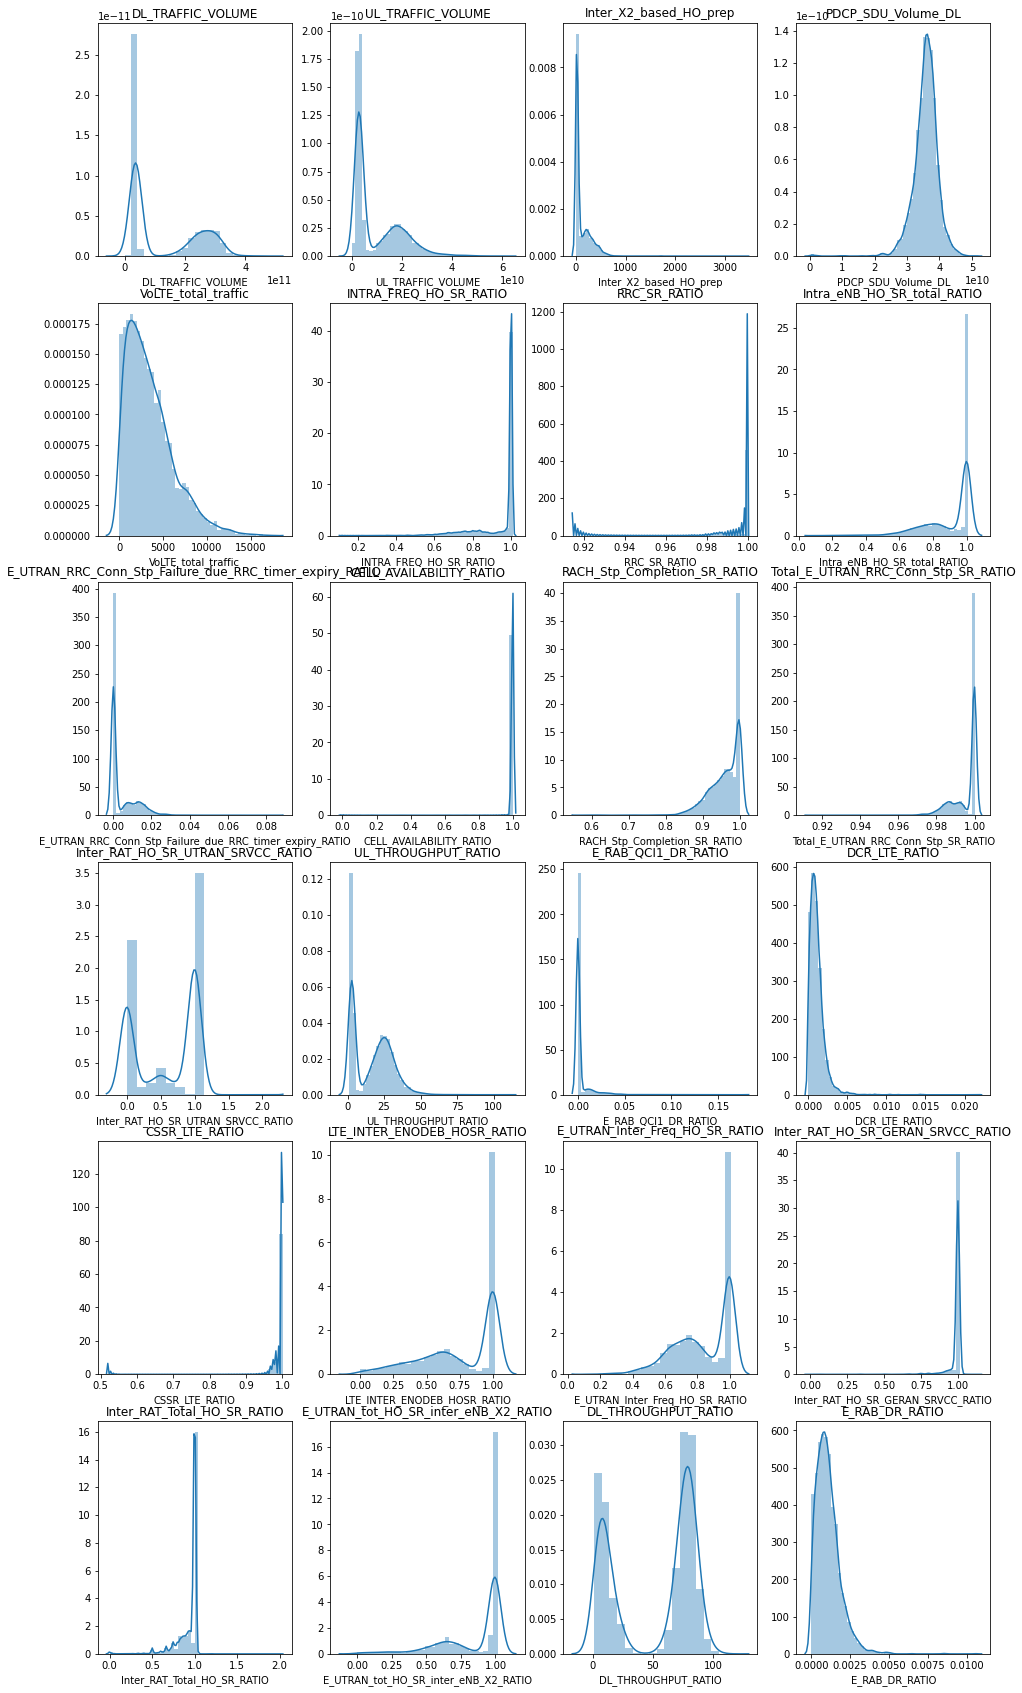

In [17]:
def get_fig_position(i,n_per_row):
        row = i/n_per_row
        col = i%n_per_row
        return int(row),int(col)
    

def showFeatureDistribution(df_features):
    """
    Input
    @df_features: a dataframe that contains the features to explore 
    """
    feature_names = df_features.columns
    feature_nb = len(feature_names)

    # plot the distribution of each feature
    n_per_row = 4
    n_rows = math.ceil(feature_nb/n_per_row)

    # plot hist
    fig,ax = plt.subplots(n_rows,n_per_row,figsize=[4*n_per_row,5*n_rows])
    for i,name in enumerate(feature_names):
        ix,iy = get_fig_position(i,n_per_row)
        axes = ax[ix][iy]
        feature = df_features[name].dropna()
        axes.set_title(name)
        #axes.hist(feature)
        sns.distplot(feature,ax=axes)
    plt.show()

    
showFeatureDistribution(df.drop(["cell_id",'index'],axis=1))

## 0.3 group data by cell_id

Check the null values in each dataframe

In [14]:
df.groupby('cell_id')

DL_TRAFFIC_VOLUME                                            \
                         count          mean           std           min   
cell_id                                                                    
7.315874e+16            1655.0  3.411462e+10  3.994520e+09  2.633089e+08   
9.106218e+16            1649.0  2.516214e+11  4.653625e+10  0.000000e+00   
2.226537e+17            1654.0  3.624713e+10  3.942532e+09  1.841076e+10   
3.844733e+17            1646.0  2.786553e+11  4.272544e+10  0.000000e+00   
4.262775e+17            1654.0  3.696596e+10  2.515512e+09  1.090273e+10   

                                                                      \
                       25%           50%           75%           max   
cell_id                                                                
7.315874e+16  3.264606e+10  3.479859e+10  3.649989e+10  4.112292e+10   
9.106218e+16  2.256967e+11  2.502591e+11  2.759512e+11  4.635228e+11   
2.226537e+17  3.377921e+10  3.613497e+10  3.860277e+10  5.126918e+10   
3.844733e+17  2.561587e+11  2.882953e+11  3.076379e+11  4.081824e+11   
4.262775e+17  3.550302e+10  3.704870e+10  3.845742e+10  4.571684e+10   

             UL_TRAFFIC_VOLUME                ... DL_THROUGHPUT_RATIO  \
                         count          mean  ...                 75%   
cell_id                                       ...                       
7.315874e+16            1655.0  2.410926e+09  ...           79.568965   
9.106218e+16            1649.0  2.079526e+10  ...            9.403942   
2.226537e+17            1654.0  3.401886e+09  ...           84.342279   
3.844733e+17            1646.0  1.874498e+10  ...           17.759667   
4.262775e+17            1654.0  3.158482e+09  ...           83.960433   

                         E_RAB_DR_RATIO                                \
                     max          count      mean       std       min   
cell_id                                                                 
7.315874e+16   89.509330         1655.0  0.000547  0.000509  0.000000   
9.106218e+16   82.403812            1.0  0.000799       NaN  0.000799   
2.226537e+17  111.745089         1654.0  0.001647  0.000838  0.000132   
3.844733e+17   82.403812            1.0  0.000799       NaN  0.000799   
4.262775e+17   99.605287         1654.0  0.001027  0.000487  0.000000   

                                                      
                   25%       50%       75%       max  
cell_id                                               
7.315874e+16  0.000196  0.000443  0.000765  0.008607  
9.106218e+16  0.000799  0.000799  0.000799  0.000799  
2.226537e+17  0.001063  0.001511  0.002068  0.010546  
3.844733e+17  0.000799  0.000799  0.000799  0.000799  
4.262775e+17  0.000693  0.000974  0.001301  0.004401  

[5 rows x 192 columns]

# 1. Data preprocessing

Fill the null values with mean of each column

## 1.1 Add 'hour' as a feature

In [33]:
def getHour(x:datetime):
    return int(x.hour)
df["HOUR"] = df['index'].map(getHour)
df[['HOUR','index']]

,HOUR,index
0,0,2021-05-09 00:00:00
1,1,2021-05-09 01:00:00
2,2,2021-05-09 02:00:00
3,3,2021-05-09 03:00:00
4,4,2021-05-09 04:00:00
...,...,...
8275,19,2021-07-16 19:00:00
8276,20,2021-07-16 20:00:00
8277,21,2021-07-16 21:00:00
8278,22,2021-07-16 22:00:00


## 1.2 Separate by Cells
Separate data by their cell_id

In [34]:
cell_ids = df["cell_id"].unique()

# A list of dataframe of different cell_id
list_cells = []
for i in range(len(cell_ids)):
    cell_id = cell_ids[i]
    list_cells.append(df[df["cell_id"]==cell_id])

## 1.3 Null values
Delete columns with too many NaN values

In [35]:
def checkNullOfEach(list_cells):
    for i in range(len(cell_ids)):
        df_cell = list_cells[i].drop("cell_id",axis=1)
        print("="*65)
        print(f"Cell Id: {cell_ids[i]}, \t Number Of Data: {len(df_cell)}")
        print("-  "*22)
        chechNull(df_cell)
        print()
        
checkNullOfEach(list_cells)

Cell Id: 2.2265366483183206e+17, 	 Number Of Data: 1655
-  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  
index                                                        0
DL_TRAFFIC_VOLUME                                            1
UL_TRAFFIC_VOLUME                                            1
Inter_X2_based_HO_prep                                       1
PDCP_SDU_Volume_DL                                           1
VoLTE_total_traffic                                          1
INTRA_FREQ_HO_SR_RATIO                                       1
RRC_SR_RATIO                                                 1
Intra_eNB_HO_SR_total_RATIO                                  1
E_UTRAN_RRC_Conn_Stp_Failure_due_RRC_timer_expiry_RATIO      1
CELL_AVAILABILITY_RATIO                                      1
RACH_Stp_Completion_SR_RATIO                                 1
Total_E_UTRAN_RRC_Conn_Stp_SR_RATIO                          1
Inter_RAT_HO_SR_UTRAN_SRVCC_RATIO                         

In [36]:
def nullPercentage(s):
    return s.isnull().sum()/len(s)
    
def dropUselessColumns(df,threshold=0.6):
    """
    Drop columns with too many nan values
    
    Input:
    @df
    @threshold: The max null values percentage to keep a column.
    """
    columns_to_drop = []
    for col in df.columns:
        if nullPercentage(df[col]) >= threshold:
            columns_to_drop.append(col)
    return df.drop(columns_to_drop,axis=1)    

In [37]:
# Drop the useless columns
list_cells = list(map(dropUselessColumns,list_cells))

# Recheck the null 
checkNullOfEach(list_cells)

Cell Id: 2.2265366483183206e+17, 	 Number Of Data: 1655
-  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  
index                                                        0
DL_TRAFFIC_VOLUME                                            1
UL_TRAFFIC_VOLUME                                            1
Inter_X2_based_HO_prep                                       1
PDCP_SDU_Volume_DL                                           1
VoLTE_total_traffic                                          1
INTRA_FREQ_HO_SR_RATIO                                       1
RRC_SR_RATIO                                                 1
Intra_eNB_HO_SR_total_RATIO                                  1
E_UTRAN_RRC_Conn_Stp_Failure_due_RRC_timer_expiry_RATIO      1
CELL_AVAILABILITY_RATIO                                      1
RACH_Stp_Completion_SR_RATIO                                 1
Total_E_UTRAN_RRC_Conn_Stp_SR_RATIO                          1
Inter_RAT_HO_SR_UTRAN_SRVCC_RATIO                         

In [38]:
for df_cell in list_cells:
    df_cell.fillna(df_cell.mean(),inplace=True)

# Recheck the null 
# checkNullOfEach(df_cells)

# 2. Modeling

In this section, we'll build a Isolation Forest model Pipeline for each dataset

**Set the model**

In [27]:
model=IsolationForest(n_estimators=150, 
                      max_samples ='auto', 
                      max_features=1)

# 3. Evaluation

In [28]:
def anomalyPercent(model, df_test):
    """
    Calculate the percentage of anomalies in the testset
    
    """
    df_pred = df_test.copy()
    df_pred['anomaly'] = model.predict(df_test)
    pct  = (df_pred['anomaly']==-1).sum()/len(df_test)
    
#     # map 1 -> 0, -1 -> 1
#     reset_value = lambda x: 1 if x==-1 else 0
#     df_test['anomaly'] = df_test['anomaly'].map(reset_value)
    
    return pct, df_pred

In [29]:
def anomaly_visualization(df):
    """
    Visualize anomalies in 2D/3D scatter plot
    
    INPUT
    @df : a dataframe where the prediction result is in the 'anomaly' column
    
    """
    index = df.index
    outlier_index = list(df[df['anomaly']==-1].index)
    
    # nomalize the metrics
    X = StandardScaler().fit_transform(df.drop('anomaly',axis=1))
    
    # recude the dimension for visualization
    X_3d = pd.DataFrame(PCA(3).fit_transform(X),index=index)
    X_3d_outliers = X_3d.reindex(outlier_index)
    X_2d = pd.DataFrame(PCA(2).fit_transform(X),index=index)
    X_2d_outliers = X_2d.reindex(outlier_index)
    
    # plot
    fig = plt.figure(figsize=(10,5))
    # 3D
    ax1 = fig.add_subplot(121,  projection='3d')
    ax1.scatter(X_3d.loc[:,0],X_3d.loc[:,1],X_3d.loc[:,2],
                s=4,lw=1,label="inliers",c="green",alpha=0.5)
    ax1.scatter(X_3d_outliers.loc[:,0], X_3d_outliers.loc[:,1], X_3d_outliers.loc[:,2],
               s=60,marker="x",lw=2,label="outliers",c="red")
    ax1.legend()
    ax1.set_title("Isolation Prediction (3D)")
    # 2D
    ax2 = fig.add_subplot(133)
    ax2.scatter(X_2d.loc[:,0],X_2d.loc[:,1],c="green",
                s=5,label="inliers",alpha=0.8)
    ax2.scatter(X_2d_outliers.iloc[:,0], X_2d_outliers.iloc[:,1],
                s=60,marker="x",lw=2,c='red',label="outliers")
    ax2.legend()
    ax2.set_title("Isolation Prediction (2D)")
    plt.show()
    

Visualization of anomalies 

cell id: 2.2265366483183206e+17
Percentage of outliers: 0.063 %


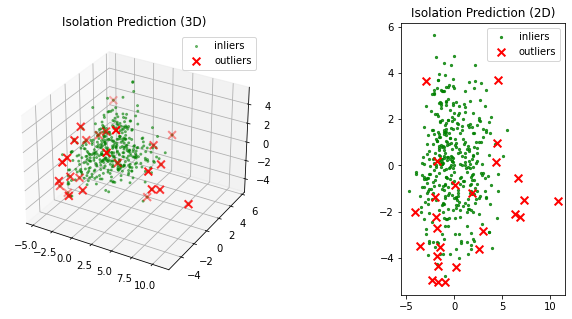




cell id: 7.315874467898523e+16
Percentage of outliers: 0.014 %


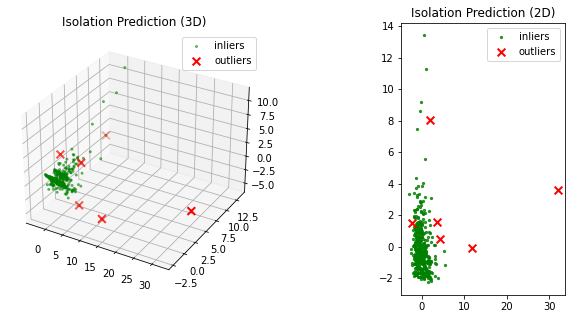




cell id: 9.10621795573706e+16
Percentage of outliers: 0.039 %


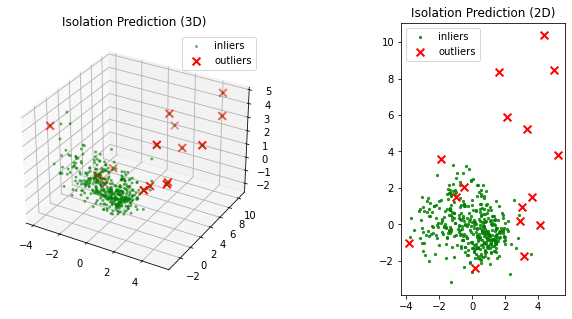




cell id: 3.8447326973958944e+17
Percentage of outliers: 0.058 %


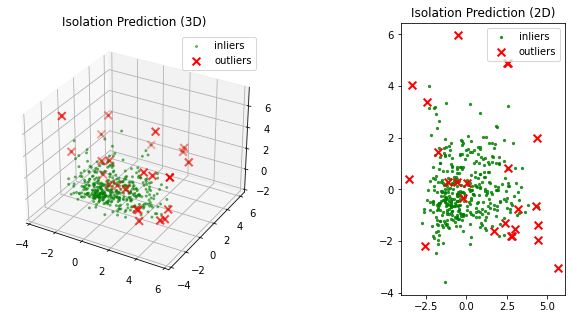




cell id: 4.262775046883192e+17
Percentage of outliers: 0.036 %


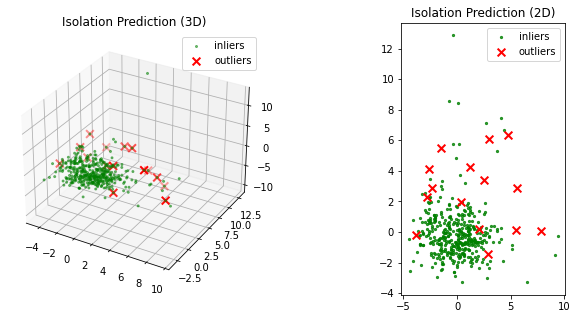

In [39]:
for i in range(len(list_cells)):
    # get the dataframe of a certain cell
    df_c = list_cells[i].drop(['cell_id','index'], axis=1)
    
    # split train set and test set 
    df_train, df_test = train_test_split(df_c)
    # train model 
    model.fit(df_train)
    pct, df_pred = anomalyPercent(model, df_test)
    print("="*75)
    print(f"cell id: {cell_ids[i]}")
    print("Percentage of outliers: %.3f %%"%pct)
    anomaly_visualization(df_pred)
    print("\n\n")